Try to fit a per-cultivar model to the automatically captured canopy height and leaf angle data for Season4

In [1]:
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
s4_df = pd.read_csv('s4_full_height_leaf_day.csv')

In [3]:
s4_df[0:5]

,canopy_height,column,cultivar,date,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,range,season,day_offset
0,15.0,2,PI453696,2017-05-13 12:00:00,2.695956,1.977380,1.756464,0.435924,43,4,12.0
1,15.0,15,PI145626,2017-05-13 12:00:00,3.265980,2.018623,1.941012,0.396782,35,4,12.0
2,19.0,2,PI257600,2017-05-13 12:00:00,2.159610,1.809209,1.638744,0.471944,42,4,12.0
3,13.0,4,PI569416,2017-05-13 12:00:00,3.042180,2.198751,1.732985,0.444099,30,4,12.0
4,17.0,2,PI585454,2017-05-15 12:00:00,2.305345,1.872028,1.665387,0.462600,45,4,14.0


In [4]:
full_df = s4_df

In [5]:
full_df.describe()

,canopy_height,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,range,season,day_offset
count,9441.000000,9441.000000,9441.000000,9441.000000,9441.000000,9441.000000,9441.000000,9441.0,9441.000000
mean,197.719203,8.541468,2.903153,1.825797,1.908666,0.419339,30.267027,4.0,56.918017
std,96.712778,4.004024,1.076542,0.321239,0.243674,0.052055,14.455791,0.0,27.400310
min,12.000000,1.000000,0.756692,0.977342,0.756736,0.246258,2.000000,4.0,12.000000
25%,114.000000,5.000000,2.103990,1.590333,1.767434,0.386807,18.000000,4.0,36.000000
50%,208.000000,9.000000,2.846314,1.817881,1.906026,0.416412,32.000000,4.0,55.000000
75%,271.000000,12.000000,3.540884,2.040797,2.048274,0.449578,43.000000,4.0,65.000000
max,412.000000,16.000000,8.647608,4.171909,4.768680,0.684988,54.000000,4.0,121.000000


In [6]:
maxColumn = full_df.describe().loc['max','column']
maxRange = full_df.describe().loc['max','range']
print('max range:',maxRange, 'max column:',maxColumn)

max range: 54.0 max column: 16.0


In [7]:
import warnings
warnings.filterwarnings(action='ignore')


In [8]:
gbr_models = {}
predictions = {}
list_of_counts = []
count = 0
grouped = full_df.groupby(['cultivar'])
for name,group in grouped:
    #print(name)
    # pick the features to use for training
    train_df = group[['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
    # identify the 'target' feature to try to predict
    target_df = group['canopy_height']
    X_train = train_df.values
    y_train = target_df.values
    # record how many points were used for training
    countRec = {'cultivar': name, 'count': X_train.shape[0]}
    list_of_counts.append(countRec)
    # train a model for this cultivar in this location and store the trained model in a dictionary
    gbr_models[name] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)
    gbr_pred = gbr_models[name].predict(X_train)
    count += 1
    # add the model results back into the dataframe so we can plot the actual and predicted against all the indepedent variables
    train_df['gboost'] = gbr_pred
    #put the actual target value back in the dataframe so we can plot results
    train_df['canopy_height'] = target_df
    # store the predicted results in the same dictionary organization and the trained models
    predictions[name] = train_df
    if (count % 50) == 0:
        print('in process:',count, 'models')
print('finished generating',count,'models')

in process: 50 models
in process: 100 models
in process: 150 models
in process: 200 models
in process: 250 models
in process: 300 models
in process: 350 models
finished generating 351 models


In [9]:
# calculate the percentage error between the actual and the model
for name in predictions:
    #print(predictions[name])
    predictions[name]['abserror_gboost'] = 100.0*abs(predictions[name]['canopy_height']-predictions[name]['gboost'])/predictions[name]['canopy_height']


In [10]:

def plot_specific_cultivar(cultivar):
    df = predictions[(cultivar)]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    print(df.shape)
    df = df[['day_offset','canopy_height','gboost','abserror_gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()

(15, 10)
            canopy_height      gboost  abserror_gboost
day_offset                                            
12.0                 15.0   15.005147         0.034315
15.0                 29.0   29.004517         0.015577
32.0                102.0  102.002803         0.002748
35.0                119.0  119.002222         0.001867
36.0                125.0  125.001835         0.001468
38.0                111.0  111.002776         0.002501
39.0                114.0  114.002326         0.002041
40.0                272.0  271.998192         0.000665
46.0                191.0  191.000547         0.000286
55.0                248.0  247.998731         0.000512
61.0                278.0  277.997905         0.000753
62.0                260.0  259.998551         0.000557
64.0                263.0  262.998439         0.000594
65.0                268.0  267.998267         0.000647
120.0               386.0  385.995164         0.001253


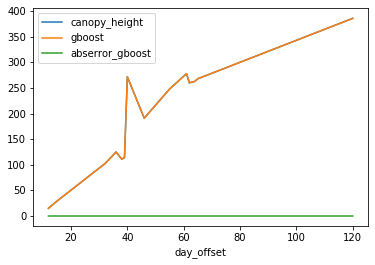

In [11]:
plot_specific_cultivar('PI453696')

In [12]:
count_df = pd.DataFrame(list_of_counts)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26c84a90>]],
      dtype=object)

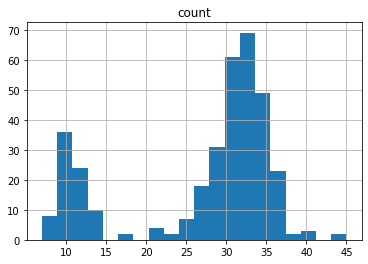

In [13]:
count_df.hist(bins=20)

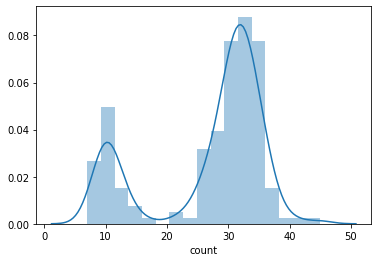

In [14]:
import seaborn as sns
sns.distplot(count_df['count'])

In [15]:
predictions['Big_Kahuna'][0:10]

,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,gboost,canopy_height,abserror_gboost
20,14.0,54,6,2.862611,2.032145,1.760535,0.440563,23.005223,23.0,0.022707
24,15.0,54,8,3.187505,2.155901,1.803197,0.430016,24.004826,24.0,0.020109
194,18.0,54,12,2.613957,1.892850,1.735935,0.454849,31.004720,31.0,0.015225
238,19.0,54,12,1.857061,1.592292,1.647838,0.481126,34.004480,34.0,0.013176
463,23.0,54,12,1.252334,1.418767,1.430102,0.527795,53.004236,53.0,0.007993
493,24.0,54,12,1.537513,1.509867,1.548146,0.500208,63.003760,63.0,0.005968
948,32.0,54,12,3.897037,2.108525,2.086252,0.370828,105.002890,105.0,0.002752
1292,33.0,54,4,4.775740,2.310997,2.209762,0.342345,113.002505,113.0,0.002217
1456,34.0,2,14,3.088966,2.040991,1.851796,0.417696,123.002317,123.0,0.001884
2140,36.0,54,15,3.995687,2.126088,2.103125,0.366124,129.002168,129.0,0.001681


We only have a single value for each cultivar, but the cultivar is placed multiple times in the field.  To plot the whole field, we have to index through the field and query the prediction results by using the cultivar name, then build up a complete view of the field.  First look at how to find the cultivar at a particular spot on the field:

In [16]:
# this query matches all the rows with specific range and column, then selects the first return (via iloc[0]) and selects only the cultivar column
s4_df.loc[(s4_df['range'] == 5) & (s4_df['column']==5)].iloc[0]['cultivar']

'PI154987'

In [17]:
def addPlotMarker(cultivar,rng,column,error):
    global plotlist
    mark = {}
    mark['cultivar'] = cultivar
    mark['range'] = rng
    mark['column'] = column
    mark['avg_error'] = error
    plotlist.append(mark)

In [19]:
import numpy as np
plotlist = []

for rng in range(2,int(maxRange)):
    for col in range(2,int(maxColumn)):
        #print(rng,col)
        CultivarListInThisSpot = s4_df.loc[(s4_df['range'] == rng) & (s4_df['column']==col)]['cultivar']
        # return a Series of the cultivar names. If the square isn't empty, get the cultivar name from the list. 
        # all cultivar names should be identical since we have selected multiple measurements (on different days) from the same location
        if len(CultivarListInThisSpot)> 0:
            thisCultivar = CultivarListInThisSpot.values[0]
            addPlotMarker(thisCultivar,rng,col,predictions[thisCultivar]['abserror_gboost'].agg(np.mean))
plotdf = pd.DataFrame(plotlist)
print('plotted',len(plotlist),'values')
plotdf.head()
#len(plotdf)

plotted 703 values


,cultivar,range,column,avg_error
0,Big_Kahuna,2,14,0.002775
1,SP1615,2,15,0.003034
2,PI329465,3,2,0.002805
3,PI22913,3,3,0.002726
4,PI145626,3,4,0.003905


Yes!  Now we have a full grid of values with the cultivar name, location, and the average error througout the season.  Let us 
plot this to see what it looks like.

In [24]:
import altair as alt
alt.Chart(plotdf, title="Season4 - model per cultivar, average canopy_height error in %").mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar:O', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Model Error %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)